# Use a pre-trained network with transfer learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process? 

This approach is called **transfer learning**, beacause we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, sush as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many case just building a classifier on top of those extracted features can yield a good result. 


In [1]:
import torch 
import torch.nn as nn 
import torchvision
from torchvision import transforms
from torchinfo import summary
import numpy as np 
import json
import requests

import os 
import matplotlib.pyplot as plt 
import zipfile

## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [2]:
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall(path='data')

In [3]:
print(os.path.exists('data/PetImages/Cat'))
print(os.path.exists('data/PetImages/Dog'))

True
True


## Loading data

In [4]:
std_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225])

trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize

])

dataset = torchvision.datasets.ImageFolder('data/PetImages', transform=trans)
train_set, test_set = torch.utils.data.random_split(dataset, [20000, len(dataset)-20000]) 


In [5]:
## Pre-trained model

vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

In [ ]:
summary(vgg,input_size=(1,3,224,224))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In addition to the layer we already know, there is also another layer type call Dropout. These layers act as **regularization** technique. Regularization makes slight modifications to the learning proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which improves overall stability of the network

## GPU computations

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

The way it is normally done is to check the availability of GPU in the code, and define `device` variable that points to the computational device - either GPU or CPU.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(281, device='cuda:0')

## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using **vgg.features** method

torch.Size([1, 512, 7, 7])


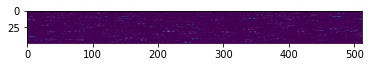

In [ ]:
res = vgg.features(sample_image).cpu()
plt.figure()
plt.imshow(res.detach().view(-1,512))
print(res.size())

The dimension of feature is 512x7x7, but in order to visualize it we had to reshape it to 2D form. 

Let's try to see if those features can be used to classify images. Let's manually take some portion of image(800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called **feature_tensor**, and also labels into **label_tensor**:

In [ ]:
bs = 8
dl = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
num = bs*100
feature_tensor = torch.zeros((num, 512*7*7)).to(device)
label_tensor = torch.zeros(num).to(device)

In [ ]:
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i: i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+= bs
        print('.', end='')
        if i >= num:
            break


....................................................................................................

In [ ]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor.to(torch.long))

train_ds, test_ds = torch.utils.data.random_split(vgg_dataset, [700, 100])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

net = nn.Sequential(nn.Linear(512*7*7,2), nn.LogSoftmax(dim=1)).to(device)



In [ ]:
def training_epoch(model, dataloader, loss_fn, optimizer):
    total_loss, acc = 0,0
    data_size = len(dataloader.dataset)
    for (X,y) in dataloader:
        (X,y) = (X.to(device), y.to(device))
        out = model(X)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, y_pred = torch.max(out, dim=1)
        total_loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
    return total_loss/(data_size), acc/(data_size)

def valid_epoch(model, dataloader, loss_fn):
    data_size = len(dataloader.dataset)
    loss, acc = 0,0
    model.eval()
    for X,y in dataloader:
        X,y = X.to(device), y.to(device)
        out = model(X)
        _, y_pred = torch.max(out, dim=1)
        loss += loss_fn(out, y).item()
        acc += (y_pred == y).type(torch.float).sum().item()
        
    return loss/(data_size), acc/(data_size)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()



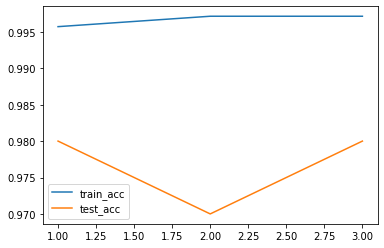

In [ ]:
train_hist = []
test_hist = []
for t in range(3):
    train_hist.append(training_epoch(net, train_loader, loss_fn, optimizer))
    with torch.no_grad():
        test_hist.append(valid_epoch(net, test_loader, loss_fn))
train_loss = [i[0] for i in train_hist]
train_acc = [i[1] for i in train_hist]
test_loss = [i[0] for i in test_hist]
test_acc = [i[1] for i in test_hist]


plt.figure()
plt.plot([x+1 for x in range(3)], train_acc)
plt.plot([x+1 for x in range(3)], test_acc)
plt.legend(['train_acc', 'test_acc'])
plt.show()

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

In [ ]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)
for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!